## imports

In [1]:
import pycaret

In [2]:
import pandas as pd
import pke
import spacy
import torch
import stanza
#import spacy_stanza
import warnings
import string
from gensim.models import KeyedVectors
#import enchant    # Pour correction orthographique de synonymes


In [141]:
import numpy as np
from numpy import around
import re
from transformers import pipeline
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelWithLMHead, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
tqdm.pandas()
warnings.filterwarnings("ignore")

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [5]:
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier

In [151]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [134]:
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [136]:
import matplotlib
import matplotlib.pyplot as plt

In [7]:
#import sklearn
#sklearn.__version__ = '0.23.2'

In [8]:
#sklearn.__version__

'0.23.2'

## Init

In [87]:
es_final= pd.read_csv('../data/corpus_es_notesv2.csv',index_col=0)

In [88]:
espa = pd.concat([es_final[[ 'title_1', 'title_2', 'text_1', 'text_2','summary1_text1', 'summary2_text1', 'summary1_text2', 'summary2_text2']],
        es_final[['Geography', 'Entities','Time', 'Narrative', 'Overall', 'Style', 'Tone']],es_final[['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'entites_idem','dates_idem', 'score_similarite_titres',
       'score_similarite_resume1', 'score_similarite_resume2','score_classif1', 'score_classif2', 'score_sentiment1', 
       'score_sentiment2', 'meth1_similarites', 'meth2_similarites']]],axis=1)

In [54]:
# remémorer numéro de ligne - compléter les Nan
espa['ligne'] = espa.index

In [89]:
# attention certains textes ne sont pas fournies et donc mis en "Error" : A supprimer donc
# On pourrait éventuellement tester en ne prenant plus les meth similarités ds les predicteurs
espa = espa[espa.meth1_similarites!='Error']

In [90]:
espa

,title_1,title_2,text_1,text_2,summary1_text1,summary2_text1,summary1_text2,summary2_text2,Geography,Entities,...,dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites
0,Se realizan compras de última hora para fin de...,Heridos de pirotecnia,"PROGRESO, Yucatán, 31 de diciembre.- Cuando al...","Este miércoles a la madrugada, en el marco de ...",El centro de la ciudad celebra el Año Nuevo en...,Los comerciantes de la zona del Malecón acudie...,"Este miércoles a la madrugada, en el marco de ...",Las consultas por quemaduras de pirotecnia se ...,4.0,4.0,...,NaN,56.754708,59.662652,63.518047,NaN,NaN,NaN,NaN,NaN,NaN
1,Realizarán obras de mejoramiento en el Bosque ...,Arica: Con ambiente festivo se inauguró la últ...,Las obras iniciarán durante el primer trimestr...,"En la Población Tarapacá Oriente, los vecinos ...",NaN,NaN,NaN,NaN,3.0,3.5,...,NaN,NaN,NaN,NaN,8.41,8.41,8.41,8.41,NaN,NaN
2,Estos son los países más peligrosos para viaja...,Condena FIP 49 asesinatos de periodistas en 2019,Es probable que uno de los propósitos más repe...,Los 49 asesinatos de este año ocurrieron en un...,NaN,NaN,NaN,NaN,2.0,4.0,...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Un niño sufrió quemaduras luego de poner una c...,Australia recibe el año 2020 con devastadores ...,01/01/2020 - 12:32 Policiales\n\nEn las última...,"Según los medios, más de 200 viviendas fueron ...",NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,Francisco pidió «disculpas» por el incidente c...,El Papa denuncia la violencia contra las mujer...,El papa Francisco pidió hoy «disculpas» por el...,"En su primera misa del año 2020, el Papa Franc...",Las obras comenzarán durante el primer trimest...,Las obras comenzarán durante el primer trimest...,Los habitantes de la Amazonia Oriente y Occide...,"En la población Tarapacá Oriente, los vecinos ...",1.0,1.0,...,NaN,51.384956,58.752096,38.829806,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,22.8
2276,NaN,NaN,NaN,NaN,El presidente Iván Duque realiza un Facebook L...,El programa de Duque posee un espacio todos lo...,Este 27 de abril las personas ya podrán salir ...,El presidente de Estados Unidos asegura que la...,NaN,NaN,...,NaN,17.165859,30.353743,29.052958,NaN,NaN,NaN,NaN,NaN,NaN
2277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,40.00,40.00,40.00,40.00,NaN,NaN
2278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
espa['meth1_similarites'] = espa['meth1_similarites'].astype('float')
espa['meth2_similarites'] = espa['meth2_similarites'].astype('float')

## Classif

In [81]:
from sklearn.utils.multiclass import type_of_target

In [92]:
#predicteurs1 = ['score_similarite_titres','score_similarite_resume1','score_similarite_resume2','score_classif1','score_classif2',
 #           'score_sentiment1','score_sentiment2']
predicteurs = ['nb_entites_idem', 'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1',
    'score_similarite_resume2', 'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites',
    'meth2_similarites']

In [93]:
datas = espa[predicteurs + ['Overall']]

In [94]:
datas

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall
0,NaN,NaN,NaN,56.754708,59.662652,63.518047,NaN,NaN,NaN,NaN,NaN,NaN,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,8.41,8.41,8.41,8.41,NaN,NaN,3.0
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.0
4,NaN,NaN,NaN,51.384956,58.752096,38.829806,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,22.8,NaN
2276,NaN,NaN,NaN,17.165859,30.353743,29.052958,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2277,NaN,NaN,NaN,NaN,NaN,NaN,40.00,40.00,40.00,40.00,NaN,NaN,NaN
2278,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
datas = datas.fillna(4.0)

In [98]:
datas

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall
0,4.0,4.0,4.0,56.754708,59.662652,63.518047,4.00,4.00,4.00,4.00,4.0,4.0,4.0
1,4.0,4.0,4.0,4.000000,4.000000,4.000000,8.41,8.41,8.41,8.41,4.0,4.0,3.0
2,0.0,0.0,0.0,4.000000,4.000000,4.000000,4.00,4.00,4.00,4.00,4.0,4.0,3.0
3,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.00,4.00,4.00,4.00,0.0,0.0,4.0
4,4.0,4.0,4.0,51.384956,58.752096,38.829806,4.00,4.00,4.00,4.00,4.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,4.0,4.0,4.0,4.000000,4.000000,4.000000,4.00,4.00,4.00,4.00,50.0,22.8,4.0
2276,4.0,4.0,4.0,17.165859,30.353743,29.052958,4.00,4.00,4.00,4.00,4.0,4.0,4.0
2277,4.0,4.0,4.0,4.000000,4.000000,4.000000,40.00,40.00,40.00,40.00,4.0,4.0,4.0
2278,1.0,0.0,0.0,4.000000,4.000000,4.000000,4.00,4.00,4.00,4.00,4.0,4.0,4.0


In [103]:
datas['Overall'] = datas['Overall'].astype('int32')

In [104]:
type_of_target(datas['Overall'])

'multiclass'

In [105]:
es_classif = setup(data = datas,  target = 'Overall', html=False, 
                   silent=True, verbose=False)

# , imputation_type='iterative'

In [106]:
lr = create_model('lr')
rf = create_model('rf')
xgb = create_model('xgboost')
ada = create_model('ada')
lda = create_model('lda')  # linear discriminant
knn = create_model('knn')
mlp = create_model('mlp')
svm = create_model('svm')
rbfsvm = create_model('rbfsvm')
nb = create_model('nb')
gpc = create_model('gpc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8194,0.4663,0.25,0.6713,0.7380,0.0,0.0
1,0.8129,0.5663,0.25,0.6608,0.7290,0.0,0.0
2,0.8129,0.4471,0.25,0.6608,0.7290,0.0,0.0
3,0.8129,0.5277,0.25,0.6608,0.7290,0.0,0.0
4,0.8129,0.5035,0.25,0.6608,0.7290,0.0,0.0
5,0.8129,0.5410,0.25,0.6608,0.7290,0.0,0.0
6,0.8182,0.4526,0.25,0.6694,0.7364,0.0,0.0
7,0.8182,0.4383,0.25,0.6694,0.7364,0.0,0.0
8,0.8182,0.5353,0.25,0.6694,0.7364,0.0,0.0
9,0.8182,0.5930,0.25,0.6694,0.7364,0.0,0.0


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7613,0.5367,0.2553,0.6819,0.7167,-0.0179,-0.0203
1,0.7742,0.5036,0.2381,0.6591,0.7120,-0.0218,-0.0285
2,0.8194,0.5768,0.3313,0.7378,0.7612,0.1649,0.2275
3,0.7806,0.5262,0.2608,0.6769,0.7215,0.0070,0.0091
4,0.7742,0.5204,0.2819,0.6900,0.7254,0.0400,0.0469
5,0.7871,0.5635,0.2921,0.7136,0.7394,0.0960,0.1124
6,0.7792,0.5664,0.2881,0.7064,0.7374,0.0837,0.0929
7,0.7727,0.4769,0.2619,0.6997,0.7258,0.0161,0.0186
8,0.7338,0.5655,0.2707,0.6914,0.7112,0.0322,0.0329
9,0.7662,0.5762,0.2341,0.6705,0.7152,-0.0122,-0.0142


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7677,0.5725,0.2343,0.6724,0.7169,-0.0111,-0.0128
1,0.7613,0.5528,0.2341,0.6525,0.7027,-0.0573,-0.0717
2,0.8065,0.6030,0.2480,0.6598,0.7258,-0.0087,-0.0257
3,0.8000,0.5276,0.2460,0.6588,0.7226,-0.0167,-0.0360
4,0.7871,0.5488,0.2858,0.7100,0.7343,0.0563,0.0704
5,0.7677,0.5653,0.2569,0.6852,0.7181,0.0134,0.0157
6,0.7857,0.5849,0.2693,0.6809,0.7279,0.0095,0.0123
7,0.8052,0.4659,0.2460,0.6719,0.7325,0.0090,0.0160
8,0.7662,0.5370,0.2599,0.6840,0.7207,0.0079,0.0089
9,0.8052,0.5660,0.2460,0.6675,0.7299,-0.0167,-0.0354


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8194,0.5411,0.2500,0.6713,0.7380,0.0000,0.0000
1,0.7871,0.5735,0.2651,0.6738,0.7256,0.0362,0.0476
2,0.8065,0.4972,0.2480,0.6598,0.7258,-0.0085,-0.0251
3,0.8129,0.4820,0.2500,0.6608,0.7290,0.0000,0.0000
4,0.8000,0.5589,0.2460,0.6632,0.7252,0.0087,0.0156
5,0.8129,0.5149,0.2500,0.6608,0.7290,0.0000,0.0000
6,0.7987,0.5073,0.2440,0.6665,0.7266,-0.0238,-0.0424
7,0.8182,0.4491,0.2500,0.6694,0.7364,0.0000,0.0000
8,0.8312,0.5161,0.3005,0.7834,0.7669,0.1410,0.2503
9,0.8182,0.5582,0.2500,0.6694,0.7364,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8194,0.4543,0.25,0.6713,0.7380,0.0,0.0
1,0.8129,0.5656,0.25,0.6608,0.7290,0.0,0.0
2,0.8129,0.4528,0.25,0.6608,0.7290,0.0,0.0
3,0.8129,0.5164,0.25,0.6608,0.7290,0.0,0.0
4,0.8129,0.4862,0.25,0.6608,0.7290,0.0,0.0
5,0.8129,0.5257,0.25,0.6608,0.7290,0.0,0.0
6,0.8182,0.4797,0.25,0.6694,0.7364,0.0,0.0
7,0.8182,0.4313,0.25,0.6694,0.7364,0.0,0.0
8,0.8182,0.5238,0.25,0.6694,0.7364,0.0,0.0
9,0.8182,0.5812,0.25,0.6694,0.7364,0.0,0.0


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7806,0.5595,0.2612,0.6888,0.7310,0.0443,0.0514
1,0.7742,0.4556,0.2381,0.6547,0.7094,-0.0449,-0.0618
2,0.7935,0.5712,0.2648,0.6865,0.7349,0.0844,0.1057
3,0.7677,0.4120,0.2361,0.6536,0.7061,-0.0524,-0.0685
4,0.7871,0.4882,0.2628,0.6883,0.7281,0.0364,0.0474
5,0.7935,0.5315,0.2440,0.6622,0.7219,0.0010,0.0016
6,0.7987,0.6147,0.2440,0.6846,0.7373,0.0689,0.0887
7,0.7987,0.5079,0.2440,0.6754,0.7319,0.0247,0.0358
8,0.7468,0.5444,0.2282,0.6769,0.7101,0.0074,0.0079
9,0.7662,0.4895,0.2341,0.6613,0.7099,-0.0570,-0.0706


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8129,0.5091,0.2480,0.6704,0.7348,-0.0085,-0.0248
1,0.8000,0.5369,0.2460,0.6632,0.7252,0.0078,0.0142
2,0.8129,0.5586,0.2500,0.6608,0.7290,0.0000,0.0000
3,0.8129,0.4950,0.2500,0.6608,0.7290,0.0000,0.0000
4,0.8065,0.5184,0.2480,0.6641,0.7284,0.0167,0.0360
5,0.8129,0.5341,0.2500,0.6608,0.7290,0.0000,0.0000
6,0.8182,0.4870,0.2500,0.6694,0.7364,0.0000,0.0000
7,0.8182,0.4955,0.2500,0.6694,0.7364,0.0000,0.0000
8,0.8117,0.5170,0.2480,0.6684,0.7331,-0.0088,-0.0256
9,0.8182,0.4941,0.2500,0.6694,0.7364,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8194,0.0,0.2500,0.6713,0.7380,0.0000,0.0000
1,0.7548,0.0,0.2321,0.6651,0.7071,-0.0005,-0.0006
2,0.6774,0.0,0.2313,0.6680,0.6717,-0.0009,-0.0009
3,0.6645,0.0,0.2734,0.6775,0.6670,0.0449,0.0471
4,0.6581,0.0,0.2646,0.6822,0.6660,0.0486,0.0512
5,0.6710,0.0,0.2961,0.6770,0.6723,0.0357,0.0361
6,0.8182,0.0,0.2500,0.6694,0.7364,0.0000,0.0000
7,0.7727,0.0,0.2361,0.6669,0.7159,-0.0302,-0.0376
8,0.4481,0.0,0.2247,0.6689,0.5257,-0.0131,-0.0175
9,0.7922,0.0,0.2421,0.6655,0.7233,-0.0301,-0.0478


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8129,0.4884,0.2480,0.6704,0.7348,-0.0083,-0.0241
1,0.8129,0.5730,0.2500,0.6608,0.7290,0.0000,0.0000
2,0.8129,0.5680,0.2500,0.6608,0.7290,0.0000,0.0000
3,0.8129,0.4326,0.2500,0.6608,0.7290,0.0000,0.0000
4,0.8129,0.4316,0.2500,0.6608,0.7290,0.0000,0.0000
5,0.8129,0.5149,0.2500,0.6608,0.7290,0.0000,0.0000
6,0.8182,0.4407,0.2500,0.6694,0.7364,0.0000,0.0000
7,0.8182,0.4854,0.2500,0.6738,0.7390,0.0266,0.0775
8,0.8182,0.4458,0.2500,0.6738,0.7390,0.0260,0.0755
9,0.8182,0.4422,0.2500,0.6694,0.7364,0.0000,0.0000


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7613,0.4963,0.2323,0.6668,0.7109,-0.0389,-0.0453
1,0.7613,0.5043,0.2599,0.6767,0.7154,0.0266,0.0299
2,0.7806,0.4491,0.2401,0.6601,0.7154,-0.0133,-0.0183
3,0.7613,0.4825,0.2864,0.6917,0.7179,0.0265,0.0299
4,0.7806,0.4558,0.2401,0.6557,0.7128,-0.0372,-0.0548
5,0.8065,0.6135,0.2480,0.6641,0.7284,0.0163,0.0351
6,0.8052,0.5355,0.2718,0.6900,0.7409,0.0562,0.0816
7,0.7987,0.5305,0.2440,0.6754,0.7319,0.0261,0.0381
8,0.7857,0.4825,0.2401,0.6644,0.7200,-0.0367,-0.0536
9,0.7987,0.4932,0.2440,0.6709,0.7292,0.0021,0.0033


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7806,0.5007,0.2382,0.6837,0.7290,0.0451,0.0524
1,0.7871,0.4077,0.2421,0.6612,0.7187,-0.0075,-0.0110
2,0.7484,0.4675,0.2509,0.6702,0.7060,-0.0063,-0.0070
3,0.7548,0.4585,0.2321,0.6514,0.6993,-0.0634,-0.0765
4,0.7613,0.3872,0.2341,0.6525,0.7027,-0.0569,-0.0712
5,0.7484,0.4576,0.2302,0.6548,0.6985,-0.0473,-0.0541
6,0.7597,0.5026,0.2529,0.7041,0.7193,0.0037,0.0041
7,0.7857,0.5151,0.2659,0.7309,0.7336,0.0313,0.0387
8,0.7922,0.5459,0.2421,0.6790,0.7313,0.0390,0.0503
9,0.7727,0.4577,0.2361,0.6669,0.7159,-0.0271,-0.0335


In [123]:
essai_classif = es_final[['Geography','Entities', 'Time', 'Narrative', 'Overall', 'Style', 'Tone','nb_entites_idem', 
    'nb_lieux_idem', 'nb_dates_idem', 'score_similarite_titres', 'score_similarite_resume1','score_similarite_resume2', 
    'score_classif1', 'score_classif2','score_sentiment1', 'score_sentiment2', 'meth1_similarites','meth2_similarites']]

In [124]:
# Si on veut utiliser faire un classemen,t supprimer ligne error puis changer les types pour meth1 meth2
essai_classif = essai_classif[essai_classif.meth1_similarites != 'Error']
essai_classif['Overall']= essai_classif['Overall'].fillna(4.0)
essai_classif = essai_classif.fillna(-1)
essai_classif['meth1_similarites'] = essai_classif['meth1_similarites'].astype('float')
essai_classif['meth2_similarites'] = essai_classif['meth2_similarites'].astype('float')
essai_classif['Overall'] = essai_classif['Overall'].astype('int32')
essai_classif.dtypes

Geography                   float64
Entities                    float64
Time                        float64
Narrative                   float64
Overall                       int32
Style                       float64
Tone                        float64
nb_entites_idem             float64
nb_lieux_idem               float64
nb_dates_idem               float64
score_similarite_titres     float64
score_similarite_resume1    float64
score_similarite_resume2    float64
score_classif1              float64
score_classif2              float64
score_sentiment1            float64
score_sentiment2            float64
meth1_similarites           float64
meth2_similarites           float64
dtype: object

In [125]:
Xtrain = essai_classif[predicteurs + ['Overall']]
spanish_classif = setup(data = Xtrain,  target = 'Overall', html=False, silent=True, verbose=False)
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7806,0.5049,0.2382,0.6791,0.7263,0.0232,0.0277
1,0.7548,0.4708,0.2303,0.6611,0.7049,-0.0682,-0.0795
2,0.7677,0.4533,0.2343,0.6633,0.7117,-0.0572,-0.0708
3,0.7742,0.5467,0.2593,0.6879,0.7276,0.0362,0.0410
4,0.7613,0.5459,0.2323,0.6668,0.7109,-0.0391,-0.0454
5,0.7419,0.5085,0.2471,0.6840,0.7117,0.0198,0.0205
6,0.7727,0.5534,0.2343,0.6722,0.7189,-0.0564,-0.0690
7,0.7468,0.5190,0.2489,0.6972,0.7097,-0.0300,-0.0329
8,0.7727,0.5418,0.2821,0.7012,0.7318,0.0557,0.0618
9,0.7727,0.5180,0.2591,0.7076,0.7286,0.0361,0.0410


In [126]:
 lda = create_model('lda')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8194,0.4589,0.25,0.6713,0.7380,0.0,0.0
1,0.8194,0.5086,0.25,0.6713,0.7380,0.0,0.0
2,0.8194,0.5091,0.25,0.6713,0.7380,0.0,0.0
3,0.8194,0.5391,0.25,0.6713,0.7380,0.0,0.0
4,0.8194,0.5451,0.25,0.6713,0.7380,0.0,0.0
5,0.8194,0.6168,0.25,0.6713,0.7380,0.0,0.0
6,0.8247,0.5864,0.25,0.6801,0.7454,0.0,0.0
7,0.8182,0.5906,0.25,0.6694,0.7364,0.0,0.0
8,0.8182,0.4557,0.25,0.6694,0.7364,0.0,0.0
9,0.8182,0.5698,0.25,0.6694,0.7364,0.0,0.0


In [127]:
# random Forest simple sur scikit learn
Xtrain = essai_classif[predicteurs].reset_index(drop=True)
ytrain = essai_classif['Overall'].reset_index(drop=True)

In [128]:
 rf = RandomForestClassifier()
rf.fit(Xtrain[:50],ytrain[:50])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
res_rf = rf.predict(Xtrain[:])
res_rf = pd.concat([Xtrain[:],ytrain[:],pd.DataFrame(res_rf,columns = ['RF'])],axis=1)
res_rf

,nb_entites_idem,nb_lieux_idem,nb_dates_idem,score_similarite_titres,score_similarite_resume1,score_similarite_resume2,score_classif1,score_classif2,score_sentiment1,score_sentiment2,meth1_similarites,meth2_similarites,Overall,RF
0,-1.0,-1.0,-1.0,56.754708,59.662652,63.518047,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,4,4
1,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,8.41,8.41,8.41,8.41,-1.0,-1.0,3,3
2,0.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,3,4
3,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.00,-1.00,-1.00,-1.00,0.0,0.0,4,1
4,-1.0,-1.0,-1.0,51.384956,58.752096,38.829806,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2204,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.00,-1.00,-1.00,-1.00,50.0,22.8,4,4
2205,-1.0,-1.0,-1.0,17.165859,30.353743,29.052958,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,4,3
2206,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,40.00,40.00,40.00,40.00,-1.0,-1.0,4,1
2207,1.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.00,-1.00,-1.00,-1.00,-1.0,-1.0,4,4


In [132]:
confusion_matrix(res_rf.Overall,res_rf.RF)

array([[ 57,  14,  27,  39],
       [ 54,  20,  28,  47],
       [ 37,  11,  26,  40],
       [605, 235, 388, 581]], dtype=int64)

In [135]:
result = permutation_importance(rf, Xtrain, ytrain, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
sorted_idx

array([ 1,  3,  4,  8,  9,  6,  7, 10,  0,  5,  2, 11], dtype=int64)

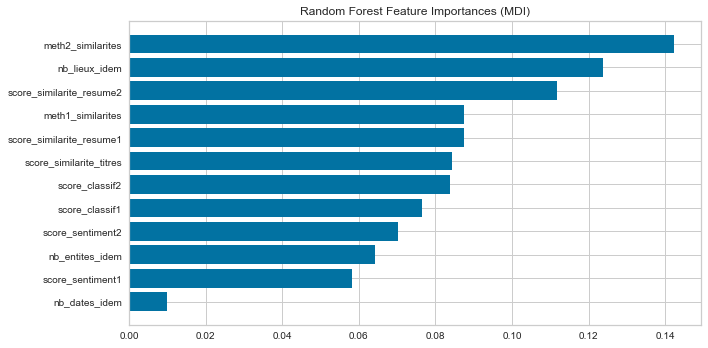

In [137]:
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(predicteurs))
fig, ax = plt.subplots(figsize = (10,5))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.array(predicteurs)[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [140]:
lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain[:],ytrain[:])
res_lda = lda.predict(Xtrain[:])
res_final = pd.concat([res_rf[['Overall','RF']],pd.DataFrame(res_lda,columns = ['LDA'])],axis=1)
res_final

,Overall,RF,LDA
0,4,4,4
1,3,3,4
2,3,4,4
3,4,1,4
4,2,2,4
...,...,...,...
2204,4,4,4
2205,4,3,4
2206,4,1,4
2207,4,4,4


In [143]:
np.set_printoptions(suppress=True)  # supprime notation exp
res_lda2 = around(lda.predict_proba(Xtrain[:])*100, decimals=2)
res_lda2

array([[ 5.98,  6.56,  6.37, 81.09],
       [ 7.01,  7.15,  5.47, 80.37],
       [ 7.56,  7.64,  6.12, 78.68],
       ...,
       [ 6.83,  6.91,  4.13, 82.14],
       [ 7.09,  6.92,  5.33, 80.65],
       [ 5.8 ,  6.94,  5.77, 81.49]])

In [144]:
res_rf2 = around(rf.predict_proba(Xtrain[:])*100, decimals=2)
res_rf2

array([[13.  , 10.  ,  3.  , 74.  ],
       [27.  ,  8.  , 61.  ,  4.  ],
       [36.47,  0.  , 21.67, 41.87],
       ...,
       [59.  ,  0.  , 41.  ,  0.  ],
       [29.11,  0.  , 12.53, 58.35],
       [30.17,  0.  ,  1.  , 68.83]])

In [145]:
# Nouveau programme basé sur les scores probas : si plus de 50% mettre catégorie obtenue sinon, faire la somme 1-2 et 3/4 
# et prendre le plus gros score puis regarder si ce sore > 65% alors à ce moment là prendre le plus gros de la catégorie 
# sinon prendre 2 ou 3
def choix_classes(score_prob):
    classe_finale = []
    for i in range(len(score_prob)):
        res = list(score_prob[i,:])
        max_res = max(res)
        if max_res > 50:
            classe_finale.append(res.index(max_res)+1)
        else:
            som1 = res[0]+res[1]
            som2 = res[2]+res[3]
            if som1 > som2:
                if som1 >= 65:
                    choix = 1 if res[0]>res[1] else 2
                else:
                    choix = 2
            else:
                if som2 >= 65:
                    choix = 4 if res[3]>res[2] else 3
                else:
                    choix = 3
            classe_finale.append(choix)
    return classe_finale

In [146]:
liste_rf = choix_classes(res_rf2)
liste_lda = choix_classes(res_lda2)
res_final = pd.concat([res_final,pd.DataFrame(liste_lda,columns = ['LDA_Prob']),
                       pd.DataFrame(liste_rf,columns = ['RF_Prob'])],axis=1)

In [148]:
knn = KNeighborsClassifier()
knn.fit(Xtrain[:],ytrain[:])
res_knn = knn.predict(Xtrain[:])
liste_knn = choix_classes(around(knn.predict_proba(Xtrain[:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['KNN']),
                      pd.DataFrame(liste_knn,columns = ['KNN_Prob'])],axis=1)

In [150]:
logreg = LogisticRegression()
logreg.fit(Xtrain[:],ytrain[:])
res_logreg = logreg.predict(Xtrain[:])
liste_logreg = choix_classes(around(logreg.predict_proba(Xtrain[:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_logreg,columns = ['LOGR']),
                      pd.DataFrame(liste_knn,columns = ['LOGR_Prob'])],axis=1)

In [153]:
ada = AdaBoostClassifier()
ada.fit(Xtrain[:],ytrain[:])
res_ada = ada.predict(Xtrain[:])
liste_ada = choix_classes(around(ada.predict_proba(Xtrain[:])*100, decimals=2))
res_final = pd.concat([res_final,pd.DataFrame(res_knn,columns = ['ADA']),
                      pd.DataFrame(liste_knn,columns = ['ADA_Prob'])],axis=1)
res_final = res_final [['Overall','RF','LDA','KNN','LOGR','ADA','RF_Prob','LDA_Prob','KNN_Prob','LOGR_Prob','ADA_Prob']]

In [154]:
res_final

,Overall,RF,LDA,KNN,LOGR,ADA,RF_Prob,LDA_Prob,KNN_Prob,LOGR_Prob,ADA_Prob
0,4,4,4,4,4,4,4,4,4,4,4
1,3,3,4,4,4,4,3,4,4,4,4
2,3,4,4,4,4,4,3,4,4,4,4
3,4,1,4,4,4,4,1,4,4,4,4
4,2,2,4,4,4,4,2,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...
2204,4,4,4,4,4,4,3,4,4,4,4
2205,4,3,4,4,4,4,3,4,4,4,4
2206,4,1,4,4,4,4,1,4,4,4,4
2207,4,4,4,4,4,4,4,4,4,4,4
